<a href="https://colab.research.google.com/github/robertdeleon98/SET_Solver/blob/main/SetSolver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# create tensorflow model to classify cards using positive images
# use tensorflow model with temp images extracted from card detector to classify cards
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# tf.test.gpu_device_name() #run to make sure tensorflow is connected to gpu
import numpy as np
import pandas as pd
import cv2
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow, subplots, show
# %matplotlib inline

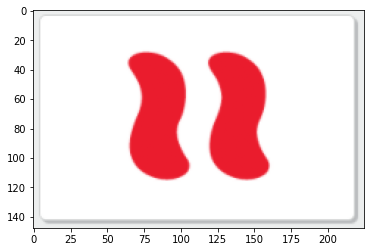

In [3]:
image = imread('image-data/positive-images/r-f-s-2.PNG')
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
imshow(images[0])
show()

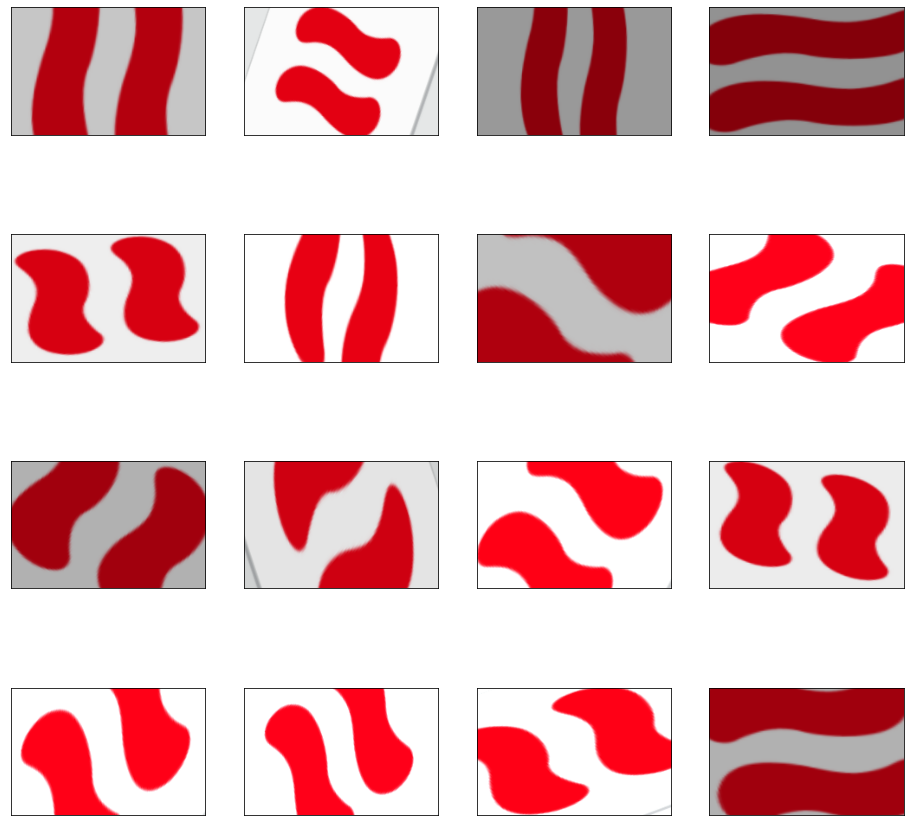

In [4]:
data_generator = ImageDataGenerator(rotation_range=90, brightness_range=(0.5, 1.5), shear_range=15.0, zoom_range=[.3, .8])
data_generator.fit(images)
image_iterator = data_generator.flow(images)

plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_iterator.next()[0].astype('int'))
plt.show()

In [5]:
data=[]

for i, img in tqdm(enumerate(os.listdir('image-data/positive-images'))):
    label=i

    img = cv2.imread('image-data/positive-images/'+img, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (180, 180))
    imgs = img.reshape((1, img.shape[0], img.shape[1], 1))
    data_generator = ImageDataGenerator(rotation_range=90, brightness_range=(0.5, 1.5), shear_range=15.0, zoom_range=[.3, .8])
    data_generator.fit(imgs)
    image_iterator = data_generator.flow(imgs)

    for x in range(50):
        img_transformed=image_iterator.next()[0].astype('int')/255
        data.append([img_transformed, label])

shuffle(data)

np.save('data.npy', data)

93it [00:13,  6.87it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [6]:
data = np.load('data.npy', allow_pickle=True)

train=data[:37000]
test=data[37000:]

train_X=[]
train_y=[]
for x in train:
    train_X.append(x[0])
    train_y.append(x[1])

test_X=[]
test_y=[]
for x in test:
    test_X.append(x[0])
    test_y.append(x[1])

train_X=np.array(train_X)
train_y=np.array(train_y)

test_X=np.array(test_X)
test_y=np.array(test_y)



tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

epochs=5
batch_size=32

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(train_X.shape[1], train_X.shape[2], train_X.shape[3])),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(93, activation='softmax')
])

model.summary()

cp = tf.keras.callbacks.ModelCheckpoint(filepath="250epochs_conv.h5",
                               save_best_only=True,
                               verbose=0)

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size,
                    validation_data=(test_X, test_y), callbacks=[cp]).history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       1

NameError: ignored

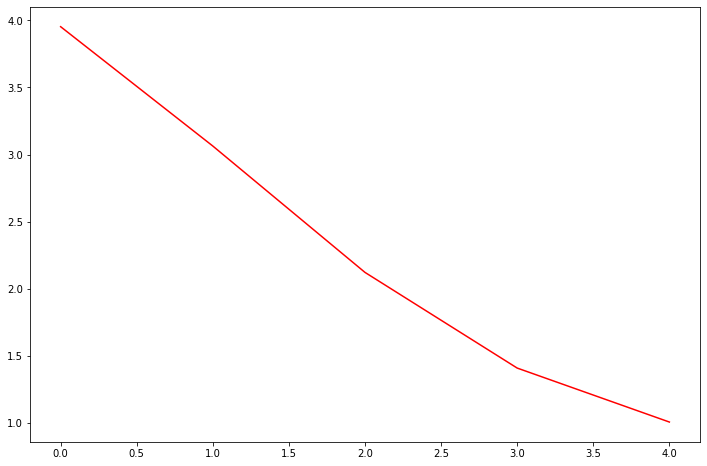

In [10]:
acc = history['accuracy']
# val_acc = history['val_accuracy']
loss = history['loss']
# val_loss = history['val_loss']
epochs = range(len(acc))

plt.figure(figsize = (12,8))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.figure(figsize = (12,8))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
df=pd.read_csv('card_labels.csv')
labels=list(df['label'])

predictions=model.predict_classes(test_X)

sample=test_X[:16]

plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample[i].reshape(sample.shape[1], sample.shape[2]))
    plt.xlabel(labels[predictions[i]])
plt.show()